In [ ]:
#mounting drive on colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#importing modules
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import pickle
from shutil import copy2
import tensorflow
import IPython

import keras
keras.backend.clear_session()

In [ ]:
#checking if we are connected to a gpu runtime
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#printing the name of GPU we're connected to
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-a6c83c74-89d8-70a8-9ef8-548d383531d8)


In [ ]:
#performing data augmentation
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_dir='/content/drive/My Drive/exp2/train/'
validation_dir='/content/drive/My Drive/exp2/val/'
test_dir='/content/drive/My Drive/exp2/test/'

In [ ]:
#loading data into generators
train_generator = train_datagen.flow_from_directory(
        train_dir,   
        batch_size=32,
        color_mode='rgb',
        shuffle=True,
        target_size=(224, 224),
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        batch_size=32,
        color_mode='rgb',
        shuffle=True,
        target_size=(224, 224),
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        batch_size=32,
        color_mode='rgb',
        shuffle=False,
        target_size=(224, 224),
        class_mode=None)

Found 15120 images belonging to 108 classes.
Found 3240 images belonging to 108 classes.
Found 3240 images belonging to 108 classes.


In [ ]:
del model

In [ ]:
#defining model's architecture
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import keras

initializer = keras.initializers.he_normal()
model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer=initializer, input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer=initializer))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer=initializer))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(108, activation='softmax', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

In [ ]:
#defining metrics for our model
from keras.metrics import top_k_categorical_accuracy

def top3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-6),
              metrics=['accuracy', top3_accuracy])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 64)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#defining required callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping
callback = EarlyStopping(monitor='val_loss',min_delta=0, 
                                            patience=20, mode='auto',verbose=0, restore_best_weights=True)

checkpoint_path = '/content/drive/My Drive/exp2/checkpointcnn.h5'
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                   save_weights_only=True,
                                   verbose=1)

In [ ]:
#training our model for 150 epochs
historycnn = model.fit_generator(
      train_generator,
      epochs=150,
      validation_data=validation_generator,
      callbacks=[callback, cp_callback],
      verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/150
473/473 [==============================] - ETA: 0s - loss: 16.4169 - accuracy: 0.0130 - top3_accuracy: 0.0384
Epoch 00001: saving model to /content/drive/My Drive/exp2/checkpointcnn.h5
473/473 [==============================] - 5296s 11s/step - loss: 16.4169 - accuracy: 0.0130 - top3_accuracy: 0.0384 - val_loss: 16.1091 - val_accuracy: 0.0164 - val_top3_accuracy: 0.0441
Epoch 2/150
473/473 [==============================] - ETA: 0s - loss: 15.9132 - accuracy: 0.0173 - top3_accuracy: 0.0501
Epoch 00002: saving model to /content/drive/My Drive/exp2/checkpointcnn.h5
473/473 [==============================] - 212s 447ms/step - loss: 15.9132 - accuracy: 0.0173 - top3_accuracy: 0.0501 - val_loss: 15.6797 - val_accuracy: 0.0225 - val_top3_accuracy: 0.0620
Epoch 3/150
473/473 [==============================] - ETA: 0s - loss: 15.4959 - accuracy: 0.0272 - top3_accuracy: 0.0696
Epoch 00003: saving model to /content/drive/My Drive/exp2/checkpointcnn.h5
473/473 [=======================

In [ ]:
#saving our model to our local storage
from joblib import dump
dump(model,'/content/drive/My Drive/exp2/cnnmodel1.joblib')
model.save('cnnmodelone.h5')

INFO:tensorflow:Assets written to: ram://8db9c91f-d037-4911-905d-3a97e01949c7/assets


Text(0.5, 1.0, 'Training and validation loss')

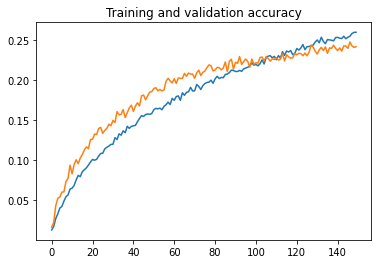

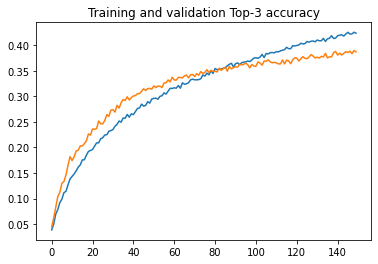

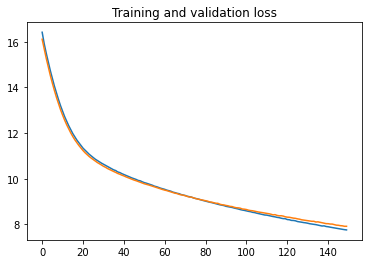

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = historycnn.history['accuracy']
val_acc = historycnn.history['val_accuracy']
top3acc = historycnn.history['top3_accuracy']
val_top3acc = historycnn.history['val_top3_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = historycnn.history['loss']
val_loss = historycnn.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, top3acc)
plt.plot(epochs, val_top3acc)
plt.title('Training and validation Top-3 accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


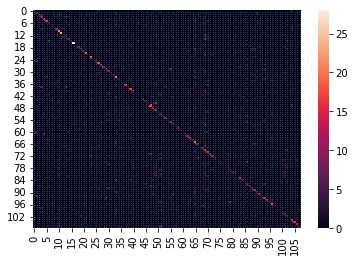

In [ ]:
#generating heatmap
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_generator.classes, y_pred)
f = sns.heatmap(cm, annot=True, annot_kws={"size": 1})

In [ ]:
#printing model performance wrt defined metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(test_generator.classes, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(test_generator.classes, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(test_generator.classes, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(test_generator.classes, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(test_generator.classes, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(test_generator.classes, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(test_generator.classes, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(test_generator.classes, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(test_generator.classes, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(test_generator.classes, y_pred, average='weighted')))

category_names=sorted(os.listdir('/content/drive/My Drive/exp2/train'))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(test_generator.classes, y_pred, target_names=category_names))


Accuracy: 0.23

Micro Precision: 0.23
Micro Recall: 0.23
Micro F1-score: 0.23

Macro Precision: 0.24
Macro Recall: 0.23
Macro F1-score: 0.21

Weighted Precision: 0.24
Weighted Recall: 0.23
Weighted F1-score: 0.21

Classification Report

                               precision    recall  f1-score   support

             Albert Bierstadt       0.24      0.17      0.20        30
               Albrecht Durer       0.17      0.23      0.19        30
             Aleksey Savrasov       0.36      0.17      0.23        30
                Alfred Sisley       0.17      0.30      0.22        30
            Amedeo Modigliani       0.42      0.43      0.43        30
             Aubrey Beardsley       0.33      0.47      0.39        30
               Berthe Morisot       0.09      0.13      0.11        30
              Boris Kustodiev       0.18      0.07      0.10        30
                Camille Corot       0.07      0.03      0.04        30
             Camille Pissarro       0.34      0.40 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetr